In [1]:
#import libraries
import pandas as pd
import numpy as np
import csv
import ast
import re
from prettytable import PrettyTable

import time
import random

#data visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.io as pio
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP & ML libraries
from gensim import corpora
from gensim.models import Word2Vec
from textblob import TextBlob
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.sparse import save_npz, load_npz


In [2]:
#set seed so that code output is deterministic
random.seed(20)  # Set the seed for Python's random module
np.random.seed(20)  # Set the seed for NumPy's random module

In [3]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


data = pd.read_csv('Data/training_corpus.csv', converters ={'tokens':list_converter})

In [4]:
data = data.drop(columns = ['index'])
print (data.shape)
data.head()

(99186, 7)


,text_type,ID,year,long_text,clean_text,word_count,tokens
0,comment,gtfo2hl,2021,"*Cuntry roads, take me hoem*",cuntry roads hoem,3,"[cuntry, road, hoem]"
1,comment,gtfqkbv,2021,"That’s been there for several years, sent a pi...",years sent pic cuntry friend long time ago,8,"[year, send, pic, cuntry, friend, long, time, ..."
2,comment,gtfou07,2021,I am single and I have not traveled to any cun...,single traveled cuntry past year,5,"[single, travel, cuntry, past, year]"
3,comment,gtfrgpe,2021,What happens when you shop at dragon mart...,happens shop dragon mart,4,"[happen, shop, dragon, mart]"
4,comment,gthiiwi,2021,"That’s just absolutely hilarious, is this in t...",absolutely hilarious springs souk,4,"[absolutely, hilarious, spring, souk]"


## **TFIDF MODEL**

In [5]:
#convert df['tokens'] to list of strings for CountVectorizer
corpus = data['tokens'].apply(lambda token: ' '.join(token)).tolist()

corpus[:5]

['cuntry road hoem',
 'year send pic cuntry friend long time ago',
 'single travel cuntry past year',
 'happen shop dragon mart',
 'absolutely hilarious spring souk']

#### **INSTANTIATE AND FIT TFIDF MODEL**

In [6]:
start_time = time.time() #track start time of execution

#instantiate CountVectorizer
tfidf = TfidfVectorizer(ngram_range = (1,2))
   
#generate document vectors 
X_tfidf = tfidf.fit_transform(corpus)
print (f"The program took {time.time() - start_time:.2f} seconds to complete. The tfidf representation had {X_tfidf.shape[1]} features.")    

The program took 6.99 seconds to complete. The tfidf representation had 811185 features.


In [7]:
#get feature names 
tfidf_features = tfidf.get_feature_names_out()
random.sample(set(tfidf_features), 5)

/var/folders/b8/lw1d456n3zv1tb19_0tkz8_80000gn/T/ipykernel_7636/831252800.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.sample(set(tfidf_features), 5)


['reddit ignorant',
 'show message',
 'cheap find',
 'archer character',
 'talk preference']

In [8]:
#tabular presentation of a sample of the bag of words representation
text_df = data['clean_text'].loc[8000:8004].copy()
tfidf_df = pd.DataFrame(X_tfidf[8000:8005].toarray(), columns = tfidf_features)

text_tfidf = tfidf_df.copy()
text_tfidf = text_tfidf.loc[:, (text_tfidf > 0.0).any()] #show only columns with at least a 1 entry for any word

text_tfidf.insert(0, 'clean_text', text_df.values) #include column of pre-processed text

text_tfidf

,clean_text,agent,agent rereading,asian,asian village,asset,asset price,aus,aus fri,brodsky,...,village,village goody,visit,visit aus,want,want check,world,world trade,year,year want
0,dubai world trade center expo site rest taken ...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.123239,0.248853,0.000000,0.000000
1,uni enjoyed felt brodsky comopolitan like town...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310233,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,visit aus fri aus,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.583292,0.411191,0.000000,...,0.000000,0.000000,0.194293,0.411191,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,kind intrigued feel reluctant time car maybe y...,0.000000,0.000000,0.149135,0.263516,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.163126,0.263516,0.000000,0.000000,0.087188,0.204639,0.000000,0.000000,0.088701,0.209028
4,real estate agent rereading sounds pro real es...,0.062845,0.112247,0.000000,0.000000,0.071281,0.108393,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


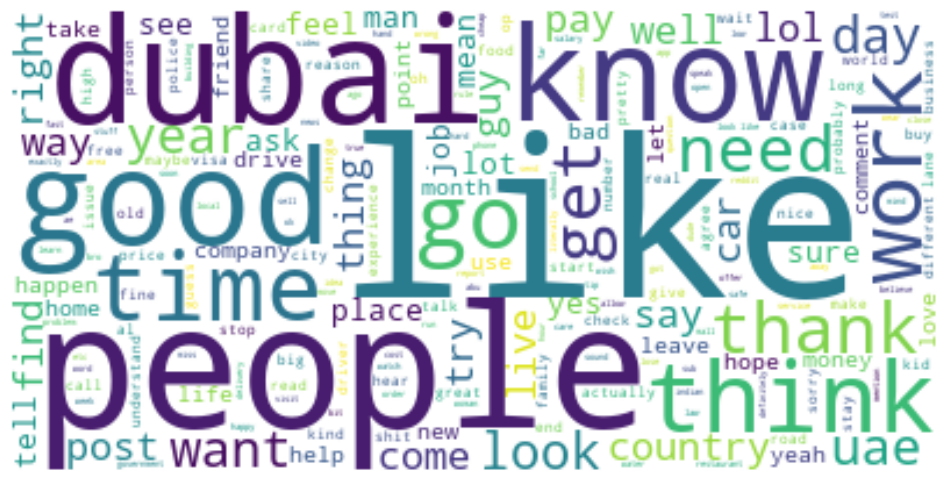

In [9]:
#visualize most common words in a wordcloud

#create tuple of word and a count of occurrence in whole corpus
word_scores = zip(tfidf_features, X_tfidf.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores_dict = dict(word_scores)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

A look at the word cloud shows that the top commonly occuring words which need to be removed. It also shows the presence of informal words which add no information in our context, and as such should be removed as well. <br>We will redo the tfidf model, after removing these words from the corpus --> a sort of additional stop word removal

## **CUSTOM STOPWORD LIST**

In [45]:
#find common and rare words using the frequency computed by the tfidf model
#common = [word for word, freq in word_scores_dict.items() if freq >=300] #list of most common words
#rare = [word for word, freq in word_scores_dict.items() if freq <=10] #list of rarely used words

#common words - NLKT freqDist
#list of all words in the dataframe
all_words = [word for token_row in data['tokens'] for word in token_row]

#frequency of word occurrence
fdist = FreqDist(all_words)

common = [word for word, freq in fdist.items() if freq>= 3000]
rare = [word for word, freq in fdist.items() if freq <=10]
other_words = [ #custom list of informal words carrying no meaning in our context
    "yeah", "okay", "ok", "lol", "omg", "brb", "btw", "imo", "imho", "ttyl", "idk", 
    "ikr", "smh", "np", "ty", "yw", "jk", "nvm", "tbh", "idc", "ily", "tmi", "wtf", 
    "wyd", "lmk", "atm", "fyi", "gtg", "g2g", "bff", "rofl", "stfu", "asap", 
    "post", "comment", "share", "like", "tweet", "follow", "update", "thread", 
    "dm", "pm", "status", "story", "tag", "meme", "emoji", "gif", "irl", "ama", 
    "tldr", "fomo", "yolo", "nsfw", "tbt", "q&a", "dms", "op", "subs", "mod", 
    "bot", "flair", "downvote", "upvote", "thread", "repost", "sidebar", "sticky", 
    "wiki", "karma", "gold", "throwaway", "username", "redditor", "crosspost", "redditor",
    "vote", "tl", "dr", "wow", "right", "sure", "definitely", "maybe", "know", "lately", 
    "probably", "r", "keep", "ae", "al", "kind", "oh", "wait", "stay", "shit", "old", "guess",
    "damn", "oh", "pretty", "hard", "reddit", "sub", "subreddit", "author", "previous", "got",
    "depend", "old", "nice", "cld", "pic", "bro", "shot", "photo", "oh", "question", "wish", "remember",
    "idea", "stuff", "fuck", "word", "second", "first", "third", "wrong", "easy", "week", "true",
    "believe", "literal", "literally", "haha", "hate", "move", "mind", "away", "yes", "big", 
    "problem", "happy", "high", "quality", "rate", "woman", "sorry", "happen", "feel", "guy", 
    "life", "try", "thank", "lot", "appreciate", "great", "help", "info", "information", "try",
    "bad", "feel", "world", "make", "lose", "love", "join", "place", "friend", "ask", "tell",
    "try", "live", "use", "hope", "soon", "let", "month", "talk", "help", "make", "different",
    "start", "issue", "mater", "hear", "leave", "actually", "person", "mention"
    "agree", "new", "though", "thought", "although", "send", "exact", "exactly", "man", "check",
    "number", "sound", "change", "close", "hour", "run", "video", "point", "wear", "wat", "far",
    "phone", "care", "understand", "kid", "dude", "reason", "ago", "speak", "miss", "free",
    "consider", "absolutely", "open", "situation", "edit", "open", "worth", "link", "watch", "video",
    "today", "head", "today", "honest", "honestly", "matter", "mention", "bit", "girl", "add", "amazing", 
    "picture", "little", "white", "able", "fact", "exist", "forget", "ah", "sense", "knowledge", "alright", 
    "group", "removal", "request", "view", "luck", "future", "buddy", "brother", "congratulation", "hey",
    "forgot", "otpion", "add", "list", "feedback", "savevideo", "video", "totally", "agree", "long", "end",
    "bit", "drop", "help", "helpful", "hand", "allow", "glad", "mate", "option", "help", "helpful", "reply",
    "instead", "save", "especially", "city", "fuck", "fucking", 'etc'
]
stopwords = list(set(common + rare + other_words))

In [46]:
#random.sample(stopwords, 10)
len(stopwords)

31942

In [47]:
# Sort the keyword dictionary by values in descending order and get the first 50 items
#top_50_words = sorted(word_scores_dict.items(), key=lambda x: x[1], reverse=True)[:50]

# Print the top 50 words and their frequencies
#for word, freq in top_50_words:
#    print(f'Word: {word}, Frequency: {freq}')

#### **TFIDF MODEL with stop_words**

In [50]:
start_time = time.time() #track start time of execution

#instantiate CountVectorizer
tfidf = TfidfVectorizer(max_features= 5000,
                        ngram_range = (1,2),
                        #token_pattern = r'(?u)\b\w\w+\b',
                        #tokenizer= None,
                        stop_words = stopwords,
                       )
   
#generate document vectors 
X_tfidf = tfidf.fit_transform(corpus)
print (f"The program took {time.time() - start_time:.2f} seconds to complete. The tfidf representation had {X_tfidf.shape[1]} features.")    

The program took 6.28 seconds to complete. The tfidf representation had 5000 features.


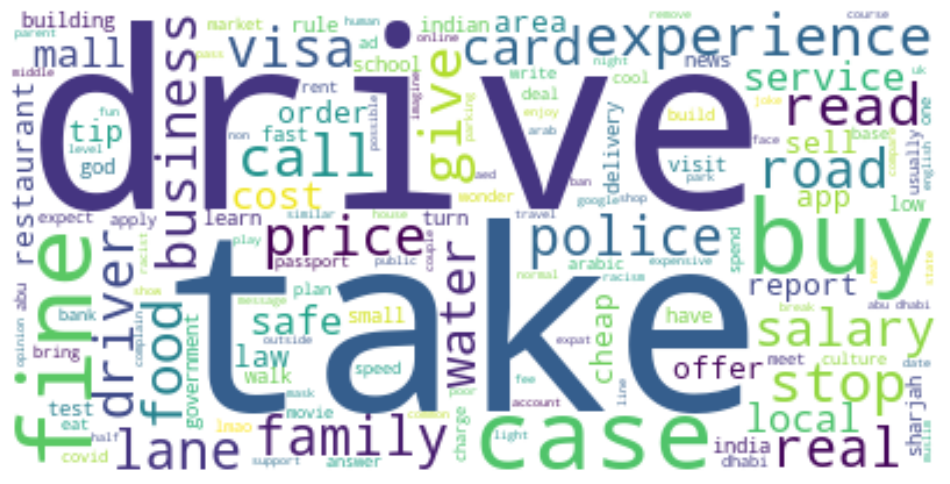

In [51]:
#visualize most common words in a wordcloud

tfidf_features = tfidf.get_feature_names_out()

#create tuple of word and a count of occurrence in whole corpus
word_scores = zip(tfidf_features, X_tfidf.sum(axis = 0).A1)

# Create a dictionary from the word_scores tuples
word_scores_dict = dict(word_scores)

#generate word cloud
wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_scores_dict)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [53]:
#confirm that stop words not in features of tfidf document vector representation
check = []
for word in tfidf_features:
    if word in stopwords:
        check.append(word)
print (len(check))

0


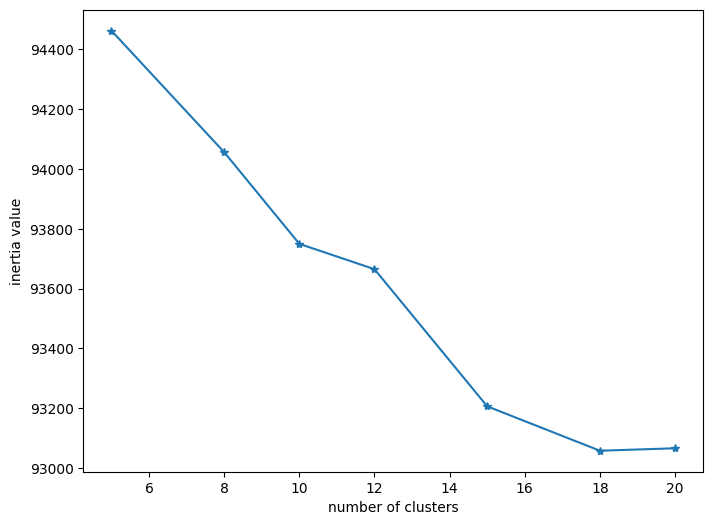

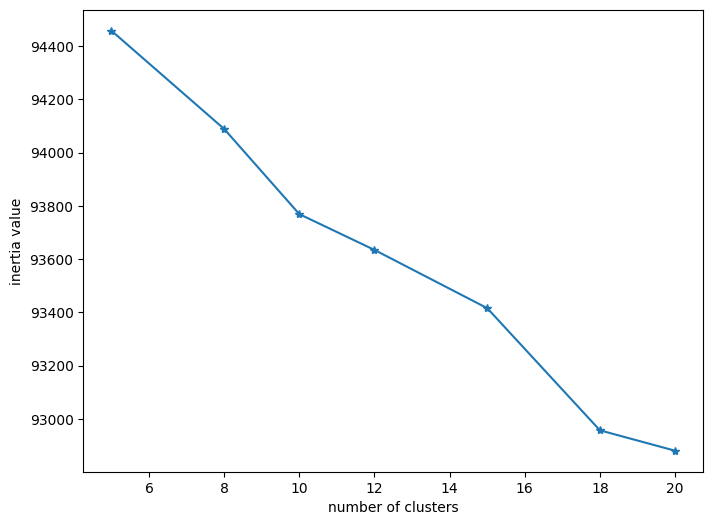

KeyboardInterrupt: 

In [55]:
%%timeit

#determine optimum k-clusters
sse_metric = []
k_range = [5,8,10,12,15,18,20]#list(range(1,21))
sil_score = {}

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, random_state = 20)#, batch_size = 5000)
    kmeans.fit(X_tfidf)
    sse_metric.append(kmeans.inertia_)
    
    #if k > 1:
    score = silhouette_score(X_tfidf, kmeans.labels_)
    sil_score.update({f'{k} clusters':score})
    
    
#plot the elbow graph of the SSE values

plt.figure(figsize=(8,6))
plt.plot(k_range, sse_metric, '-*')
plt.xlabel('number of clusters')
plt.ylabel('inertia value')

plt.show()